# John Zeiders (jzeiders) - Assignment 1

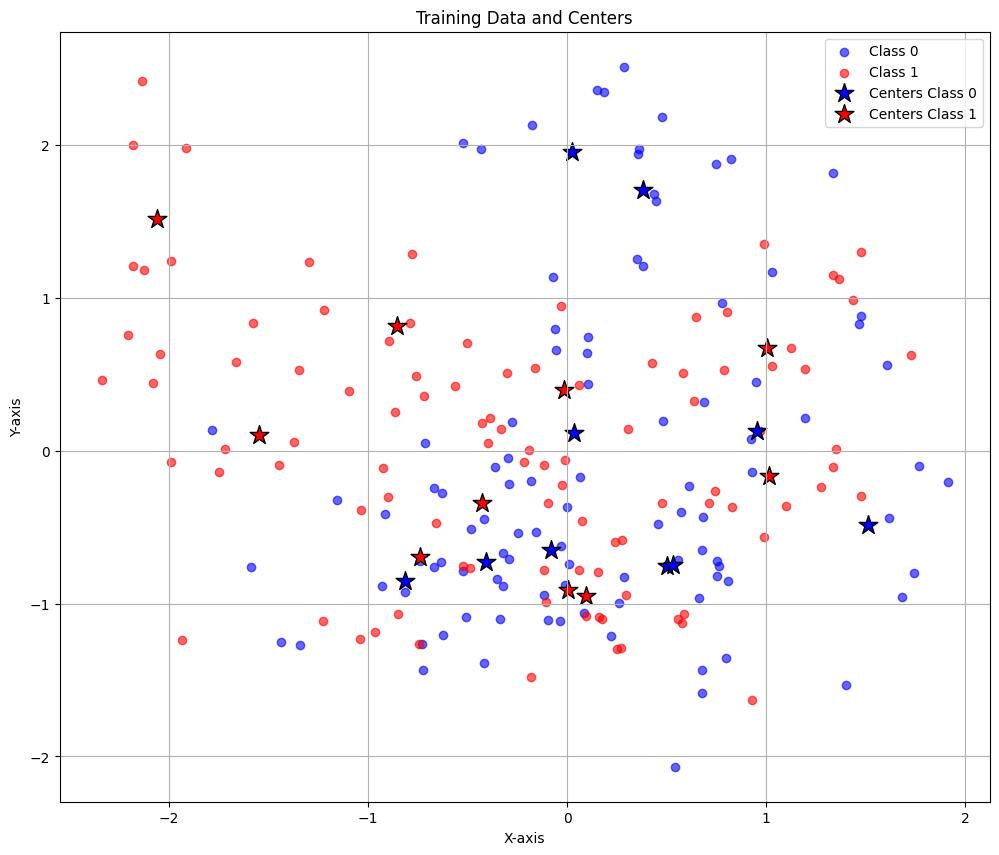

In [124]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(9628)

# Constants
NUM_CLASSES = 2
CENTERS_PER_CLASS = 10
S2 = 1/5
TRAIN_SAMPLES_PER_CLASS = 100
TEST_SAMPLES_PER_CLASS = 5000

def generate_centers(mean=[0, 0], cov=[[1, 0], [0, 1]], total_centers=20):
    centers = np.random.multivariate_normal(mean=mean, cov=cov, size=total_centers)
    centers_class0 = centers[:CENTERS_PER_CLASS]
    centers_class1 = centers[CENTERS_PER_CLASS:]
    return centers_class0, centers_class1

def generate_data(centers, n_samples, s2=S2):
    # Randomly choose centers for each sample
    selected_centers = centers[np.random.choice(len(centers), n_samples)]
    
    # Generate samples from the selected centers
    noise = np.random.multivariate_normal(mean=[0, 0], cov=s2 * np.eye(2), size=n_samples)
    samples = selected_centers + noise
    
    # Assign labels based on the class
    # Assuming class_label is known externally
    return samples

def get_structured_data(class_0_centers, class_1_centers, n_test, n_train):
    
    # Generate training data
    train_samples_class0 = generate_data(class_0_centers, n_train)
    train_samples_class1 = generate_data(class_1_centers, n_train)

    # Generate test data
    test_samples_class0 = generate_data(class_0_centers, n_test)
    test_samples_class1 = generate_data(class_1_centers, n_test)

    # Create labels
    train_labels_class0 = np.zeros(n_train, dtype=int)
    train_labels_class1 = np.ones(n_train, dtype=int)
    test_labels_class0 = np.zeros(n_test, dtype=int)
    test_labels_class1 = np.ones(n_test, dtype=int)

    # Combine training data
    train_samples = np.vstack((train_samples_class0, train_samples_class1))
    train_labels = np.concatenate((train_labels_class0, train_labels_class1))

    # Combine test data
    test_samples = np.vstack((test_samples_class0, test_samples_class1))
    test_labels = np.concatenate((test_labels_class0, test_labels_class1))
    
    return train_samples, train_labels, test_samples, test_labels




# Generate 20 centers and split into two classes
centers_class0, centers_class1 = generate_centers()
centers = np.vstack((centers_class0, centers_class1))


train_samples, train_labels, test_samples, test_labels = get_structured_data(centers_class0, centers_class1, TEST_SAMPLES_PER_CLASS, TRAIN_SAMPLES_PER_CLASS)
train_samples_class0 = train_samples[train_labels == 0]
train_samples_class1 = train_samples[train_labels == 1]
test_samples_class0 = test_samples[test_labels == 0]
test_samples_class1 = test_samples[test_labels == 1]

# Plotting
plt.figure(figsize=(12, 10))

# Plot training samples
plt.scatter(train_samples_class0[:, 0], train_samples_class0[:, 1],
            c='blue', alpha=0.6, label='Class 0')
plt.scatter(train_samples_class1[:, 0], train_samples_class1[:, 1],
            c='red', alpha=0.6, label='Class 1')

# Overlay centers
plt.scatter(centers_class0[:, 0], centers_class0[:, 1],
            c='blue', marker='*', s=200, edgecolors='k', label='Centers Class 0')
plt.scatter(centers_class1[:, 0], centers_class1[:, 1],
            c='red', marker='*', s=200, edgecolors='k', label='Centers Class 1')

plt.title('Training Data and Centers')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

# Checks
assert centers_class0.shape[0] == 10
assert centers_class1.shape[0] == 10
assert train_samples_class0.shape[0] == 100
assert train_samples_class1.shape[0] == 100
assert test_samples_class0.shape[0] == 5000
assert test_samples_class1.shape[0] == 5000


In [125]:
from sklearn.neighbors import KNeighborsClassifier

def confusion_matrix(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TP = np.sum((y_true == 1) & (y_pred == 1))
    
    cm = np.array([[TN, FP],
                   [FN, TP]])
    
    return cm

def accuracy_score(y_true, y_pred):    
    correct_predictions = np.sum(y_true == y_pred)
    accuracy = correct_predictions / len(y_true)
    
    return accuracy

# Part 2
def pairwise_distances(X, Y):
    X_squared = np.sum(X**2, axis=1, keepdims=True)
    Y_squared = np.sum(Y**2, axis=1)
    XY = np.dot(X, Y.T)
    squared_distances = X_squared + Y_squared - 2 * XY
    return np.sqrt(np.maximum(squared_distances, 0))

def knn(train_data, train_labels, test_data, k=3):
    assert train_data.shape[0] == train_labels.shape[0], "Mismatch in number of training samples and labels."
    assert train_data.shape[1] == test_data.shape[1], "Mismatch in number of features between training and test data."

    # Compute distances
    distances = pairwise_distances(test_data, train_data)
    assert distances.shape == (test_data.shape[0], train_data.shape[0]), "Incorrect shape of distance matrix."

    # Get indices of k nearest neighbors
    sorted_indices = np.argsort(distances, axis=1)[:, :k]
    assert sorted_indices.shape == (test_data.shape[0], k), "Incorrect shape of sorted indices."

    # Retrieve the labels of the k nearest neighbors
    nearest_labels = train_labels[sorted_indices]

    # Count the number of Class 1 neighbors
    class_1_counts = np.sum(nearest_labels, axis=1)


    predictions = (class_1_counts > (k / 2)).astype(int)

    return predictions

def evaluate_knn(k_values, train_data, train_labels, test_data, test_labels):
    for k in k_values:
        print(f"\n=== Evaluating kNN with k={k} ===")

        # Custom kNN
        custom_preds = knn(train_data, train_labels, test_data, k=k)
        custom_cm = confusion_matrix(test_labels, custom_preds)
        custom_acc = accuracy_score(test_labels, custom_preds)
        print("Custom kNN Confusion Matrix:")
        print(custom_cm)
        print(f"Custom kNN Accuracy: {custom_acc:.4f}")

        # Scikit-learn kNN
        knn_sklearn = KNeighborsClassifier(n_neighbors=k)
        knn_sklearn.fit(train_data, train_labels)
        sklearn_preds = knn_sklearn.predict(test_data)
        sklearn_cm = confusion_matrix(test_labels, sklearn_preds)
        sklearn_acc = accuracy_score(test_labels, sklearn_preds)
        print("Scikit-learn kNN Confusion Matrix:")
        print(sklearn_cm)
        print(f"Scikit-learn kNN Accuracy: {sklearn_acc:.4f}")

        # Compare Predictions (Optional)
        # print(f"Prediction Match: {np.array_equal(custom_preds, sklearn_preds)}"))


K_VALUES = [1, 3, 5]
evaluate_knn(K_VALUES, train_samples, train_labels, test_samples, test_labels)




=== Evaluating kNN with k=1 ===
Custom kNN Confusion Matrix:
[[3250 1750]
 [2043 2957]]
Custom kNN Accuracy: 0.6207
Scikit-learn kNN Confusion Matrix:
[[3250 1750]
 [2043 2957]]
Scikit-learn kNN Accuracy: 0.6207

=== Evaluating kNN with k=3 ===
Custom kNN Confusion Matrix:
[[3313 1687]
 [2045 2955]]
Custom kNN Accuracy: 0.6268
Scikit-learn kNN Confusion Matrix:
[[3313 1687]
 [2045 2955]]
Scikit-learn kNN Accuracy: 0.6268

=== Evaluating kNN with k=5 ===
Custom kNN Confusion Matrix:
[[3146 1854]
 [1834 3166]]
Custom kNN Accuracy: 0.6312
Scikit-learn kNN Confusion Matrix:
[[3146 1854]
 [1834 3166]]
Scikit-learn kNN Accuracy: 0.6312


Distance ties are handled by argmax default, which takes the first element, thus the sample that is earlier in the generated array.
Voting ties are handled by favoring class 0 which reduces accuracy in even k cases.

In [126]:
# Part 3
def cross_validation_manual(X, y, k_fold, ks):
    n = len(X)
    fold_size = n // k_fold
    
    accuracies = np.zeros((len(ks), k_fold))
    for k_idx in range(len(ks)):

        for i in range(k_fold):
            start = i * fold_size
            end = (i + 1) * fold_size if i != k_fold - 1 else n
            X_train = np.concatenate([X[:start], X[end:]])
            y_train = np.concatenate([y[:start], y[end:]])
            assert len(X_train) == n - fold_size
            assert len(y_train) == n - fold_size
            X_val = X[start:end]
            y_val = y[start:end]

            assert len(X_val) == fold_size
            assert len(y_val) == fold_size

            knn = KNeighborsClassifier(n_neighbors=ks[k_idx])
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            accuracies[k_idx][i] += sum(y_pred == y_val)
    accuracies = np.sum(accuracies, axis=1) / float(n)

    best_k_idx = np.argmax(accuracies)
    best_k = ks[best_k_idx]

    return best_k, accuracies[best_k_idx]

# Perform cross-validation to find the best k
K_FOLD = 10
KS = range(1, 181)


best_k, accuracy = cross_validation_manual(train_samples, train_labels, K_FOLD, KS)
print(f"Best K: {best_k} with Cross-Validation Accuracy: {accuracy:.4f}")

# Train KNN with the best k on the entire training set
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(train_samples, train_labels)

# Predict on the test set
y_test_pred = knn_best.predict(test_samples)

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, print accuracy on test data
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f"Test Error: {1- test_accuracy:.4f}")

Best K: 1 with Cross-Validation Accuracy: 0.6200
Confusion Matrix:
[[3250 1750]
 [2043 2957]]
Test Error: 0.3793


In [127]:
# Part 4
def bayes_rule(X_test, centers, s2):
    _, n_features = X_test.shape
    n_centers = centers.shape[0] // 2  # Assuming equal centers for each class
    
    # Reshape centers for broadcasting
    centers_reshaped = centers.reshape(2, n_centers, n_features)
    
    # Calculate squared Euclidean distances
    distances = np.sum((X_test[:, np.newaxis, np.newaxis, :] - centers_reshaped[np.newaxis, :, :, :]) ** 2, axis=3)
    
    # Calculate exponential terms
    exp_terms = np.exp(-distances / (2 * s2))
    
    # Sum over centers for each class
    class_probs = np.sum(exp_terms, axis=2)
    
    # Calculate the ratio
    ratio = class_probs[:, 1] / class_probs[:, 0]
    
    # Make predictions
    predictions = (ratio >= 1).astype(int)
    
    return predictions

# Test the function
y_pred = bayes_rule(test_samples, centers, S2)
conf_matrix = confusion_matrix(test_labels, y_pred)

print("Confusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[3789 1211]
 [1987 3013]]


In [128]:
def get_data_sets_for_simulation(n_simulations):
    """
    Generates training and test data sets for a simulation study.

    Parameters:
    - n_simulations: int, number of simulations to run
    - centers: np.ndarray of shape (2 * n_centers, n_features)
    - train_size: int, number of training samples per simulation
    - test_size: int, number of test samples per simulation
    - s2: float, variance parameter for data generation
    - k_range: iterable, range of K values to try in cross-validation

    Returns:
    - data_sets: list of tuple, each containing (X_train, y_train, X_test, y_test)
    """
    data_sets = []
    for sim in range(n_simulations):
        # Generate training data
        train_samples, train_labels, test_samples, test_labels = get_structured_data(centers_class0, centers_class1, TEST_SAMPLES_PER_CLASS, TRAIN_SAMPLES_PER_CLASS)
        data_sets.append((train_samples, train_labels, test_samples, test_labels))
    return data_sets
simulation_data = get_data_sets_for_simulation(50)

def simulation_study(data_set):
    train_samples, train_labels, test_samples, test_labels = data_set

    Knn = KNeighborsClassifier(n_neighbors=7)
    Knn.fit(train_samples, train_labels)
    y_pred = Knn.predict(test_samples)
    accuracy = accuracy_score(test_labels, y_pred)
    k_nn_err = 1 - accuracy
    
    y_pred = bayes_rule(test_samples, centers, S2)
    accuracy = accuracy_score(test_labels, y_pred)
    bayes_err = 1 - accuracy

    best_k, accuracy = cross_validation_manual(train_samples, train_labels, K_FOLD, KS)
    Knn_cvv = KNeighborsClassifier(n_neighbors=best_k)
    Knn_cvv.fit(train_samples, train_labels)
    y_pred = Knn_cvv.predict(test_samples)
    accuracy = accuracy_score(test_labels, y_pred)
    cvv_err = 1 - accuracy

    return best_k, k_nn_err, bayes_err, cvv_err

def run_simulation_study(data_sets):
    knn_errors = []
    bayes_errors = []
    cvv_errors = []
    best_k_values = []

    for data_set in data_sets:
        best_k, k_nn_err, bayes_err, cvv_err = simulation_study(data_set)
        knn_errors.append(k_nn_err)
        bayes_errors.append(bayes_err)
        cvv_errors.append(cvv_err)
        best_k_values.append(best_k)

    return knn_errors, bayes_errors, cvv_errors, best_k_values


knn_errors, bayes_errors, cvv_errors, best_k_values = run_simulation_study(simulation_data)







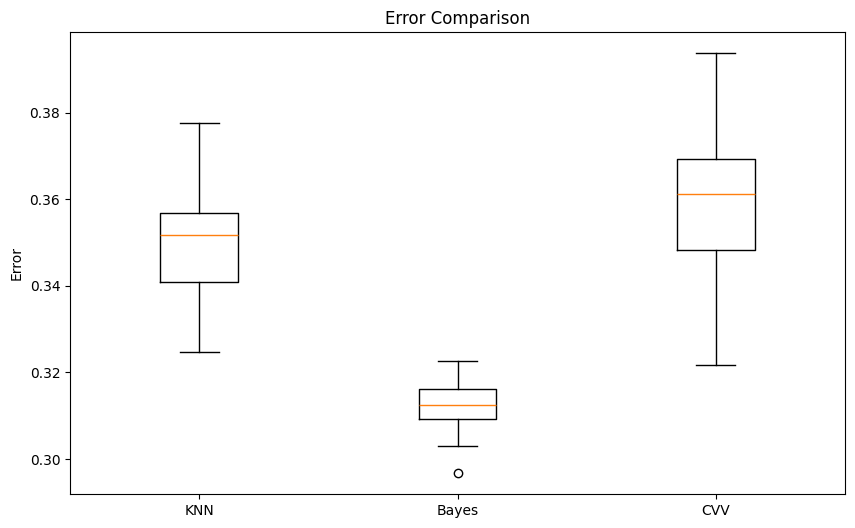


Five-number summary of the 50 selected K values:
Minimum: 1
25% quantile: 2.0
Median: 3.0
75% quantile: 5.75
Maximum: 17


In [129]:
# box plot of data
plt.figure(figsize=(10, 6))
plt.boxplot([knn_errors, bayes_errors, cvv_errors], tick_labels=['KNN', 'Bayes', 'CVV'])
plt.title('Error Comparison')
plt.ylabel('Error')
plt.show()

def five_number_summary(data):
    return {
        'min': np.min(data),
        'max': np.max(data),
        'median': np.median(data),
        '25%': np.percentile(data, 25),
        '75%': np.percentile(data, 75)
    }
k_summary = five_number_summary(best_k_values)
print("\nFive-number summary of the 50 selected K values:")
print(f"Minimum: {k_summary['min']}")
print(f"25% quantile: {k_summary['25%']}")
print(f"Median: {k_summary['median']}")
print(f"75% quantile: {k_summary['75%']}")
print(f"Maximum: {k_summary['max']}")
